In [1]:
import yaml
import argparse
from math import inf
from math import log
import pickle
from BCBio import GFF
import pandas as pd
import gffutils
from Bio import SeqIO
from collections import Counter
import numpy as np
from numpy import inf
from math import log
import os.path
from Bio import SeqIO

In [2]:
def read_config_anno(filename,database_name):
    if(os.path.isfile(database_name)==False): 
        print("creating database")
        db = gffutils.create_db(filename, dbfn=database_name, force=True, keep_order=True)
    else:
        print("reading database")
        db = gffutils.FeatureDB(database_name, keep_order=True)
    #print(db)
    dict_keys=[]
    for cds in db.features_of_type('CDS'):
        #print(list(cds.astuple()))
        current_line=list(cds.astuple())
        if current_line[1] not in dict_keys:
            dict_keys.append(current_line[1])
    anno_dict={k: [] for k in dict_keys}
    for cds in db.features_of_type('CDS'):
        current_line=list(cds.astuple())
        if current_line[7]=='+':
            segment = (int(current_line[4]), int(current_line[5]))
            anno_dict[current_line[1]].append(segment)
    #print(anno_dict)
    return anno_dict
def read_seq(fasta):
    SEQS=[]
    SEQ_NAME=[]
    SEQS_DICT={}
    for seq_record in SeqIO.parse(fasta, "fasta"):
        print(seq_record.id)
        print(repr(seq_record.seq))
        print(len(seq_record))
        SEQS.append(str(seq_record.seq))
        SEQ_NAME.append(str(seq_record.id))
        SEQS_DICT[str(seq_record.id)]=str(seq_record.seq)
    return SEQS, SEQ_NAME, SEQS_DICT 

In [3]:

def read_my_anno(filename,seq_name_list,anno_dict):
    anno_file = open(filename,'r')
    anno_data = anno_file.readlines()
    gene_total_count = 0
    gene_correct_count = 0
    my_anno_dict = {}
    for name in seq_name_list:
        my_anno_dict[name] = []
    
    for line in anno_data:
        if line.startswith('###'):
            continue
        gene_total_count += 1
        anno = line.strip().split()
        seq_name = anno[0]
        my_anno_dict[seq_name].append((int(anno[3]), int(anno[4])))
        if seq_name in anno_dict.keys():
            print(seq_name,anno[3],anno[4],anno_dict[seq_name])
            if (int(anno[3]), int(anno[4])) in anno_dict[seq_name]:
                gene_correct_count += 1
    print('accuracy', gene_correct_count/gene_total_count)
    return my_anno_dict


In [4]:
def report_performance(seq_name_list,anno_dict,predict_anno_dict,output_name):
    perfect_match_dict = {}
    start_match_dict = {}
    end_match_dict = {}
    neither_match_dict = {}
    unmatch_dict={}
    start_match_number=0
    end_match_number=0
    perfect_match_number=0
    gene_count=0
    for name in seq_name_list:
        perfect_match_dict[name] = []
        start_match_dict[name] = []
        end_match_dict[name] = []
        neither_match_dict[name] = []
        unmatch_dict[name]=[]
        

    for seq_name in anno_dict:
        gene_count+=len(anno_dict[seq_name])
        if seq_name in predict_anno_dict.keys():
            for gene in anno_dict[seq_name]:
                #1.perfectly match
                #gene_count+=1
                if gene in predict_anno_dict[seq_name]:
                    perfect_match_dict[seq_name].append(gene)
                    perfect_match_number+=1
                elif gene[0] in [i[0] for i in predict_anno_dict[seq_name]]:
                    start_match_dict[seq_name].append(gene)
                    unmatch_dict[seq_name].append(gene)
                    start_match_number+=1
                elif gene[1] in [i[1] for i in predict_anno_dict[seq_name]]:
                    end_match_dict[seq_name].append(gene)
                    unmatch_dict[seq_name].append(gene)
                    end_match_number+=1
                else:
                    neither_match_dict[seq_name].append(gene)
                    unmatch_dict[seq_name].append(gene)
    print(perfect_match_number, start_match_number,end_match_number,gene_count)
    print('perfect accuracy', perfect_match_number/gene_count)
    print('start accuracy', start_match_number/gene_count)
    print('end accuracy', end_match_number/gene_count)
    

    result_file = open(output_name, 'w')
    result_file.write('###  Perfectly match both ends of one of my predicted genes\n')
    for seq_name in anno_dict:
        for gene in perfect_match_dict[seq_name]:
            result_file.write(seq_name+'\t ena\t CDS \t {}\t {}\t . \t +\t 0\t .\n'.format(gene[0], gene[1]))
    result_file.write('###  Match the start but not the end of a predicted gene\n')
    for seq_name in anno_dict:
        for gene in start_match_dict[seq_name]:
            result_file.write(seq_name+'\t ena\t CDS \t {}\t {}\t . \t +\t 0\t .\n'.format(gene[0], gene[1]))
    result_file.write('###  Match the end but not the start of a predicted gene\n')
    for seq_name in anno_dict:
        for gene in end_match_dict[seq_name]:
            result_file.write(seq_name+'\t ena\t CDS \t {}\t {}\t . \t +\t 0\t .\n'.format(gene[0], gene[1]))
    result_file.write('###  Do not match neither the start not the end of a predicted gene\n')
    for seq_name in anno_dict:
        for gene in neither_match_dict[seq_name]:
            result_file.write(seq_name+'\t ena\t CDS \t {}\t {}\t . \t +\t 0\t .\n'.format(gene[0], gene[1]))
    result_file.close()
    return  perfect_match_dict,unmatch_dict

def report_my_anno(seq_name_list,anno_dict,predict_anno_dict,output_name):
    perfect_match_dict = {}
    start_match_dict = {}
    end_match_dict = {}
    neither_match_dict = {}
    unmatch_dict={}
    start_match_number=0
    end_match_number=0
    perfect_match_number=0
    gene_count=0
    for name in seq_name_list:
        perfect_match_dict[name] = []
        start_match_dict[name] = []
        end_match_dict[name] = []
        neither_match_dict[name] = []
        unmatch_dict[name]=[]

    for seq_name in predict_anno_dict:
        gene_count+=len(predict_anno_dict[seq_name])
        if seq_name in anno_dict.keys():
            for gene in predict_anno_dict[seq_name]:
                #1.perfectly match
                #print(type(gene[0]),type(anno_dict[seq_name][0][0]))
                if (gene[0],gene[1]) in anno_dict[seq_name]:
                    perfect_match_dict[seq_name].append(gene)
                    perfect_match_number+=1
                elif gene[0] in [i[0] for i in anno_dict[seq_name]]:
                    start_match_dict[seq_name].append(gene)
                    unmatch_dict[seq_name].append(gene)
                    start_match_number+=1
                elif gene[1] in [i[1] for i in anno_dict[seq_name]]:
                    end_match_dict[seq_name].append(gene)
                    unmatch_dict[seq_name].append(gene)
                    end_match_number+=1
                else:
                    neither_match_dict[seq_name].append(gene)
                    unmatch_dict[seq_name].append(gene)
    print(perfect_match_number, start_match_number,end_match_number,gene_count)
    print('perfect accuracy', perfect_match_number/gene_count)
    print('start accuracy', start_match_number/gene_count)
    print('end accuracy', end_match_number/gene_count)
    result_file = open(output_name, 'w')
    result_file.write('###  Perfectly match both ends of one of my predicted genes\n')
    for seq_name in anno_dict:
        for gene in perfect_match_dict[seq_name]:
            result_file.write(seq_name+'\t ena\t CDS \t {}\t {}\t . \t +\t 0\t .\n'.format(gene[0], gene[1]))
    result_file.write('###  Match the start but not the end of a predicted gene\n')
    for seq_name in anno_dict:
        for gene in start_match_dict[seq_name]:
            result_file.write(seq_name+'\t ena\t CDS \t {}\t {}\t . \t +\t 0\t .\n'.format(gene[0], gene[1]))
    result_file.write('###  Match the end but not the start of a predicted gene\n')
    for seq_name in anno_dict:
        for gene in end_match_dict[seq_name]:
            result_file.write(seq_name+'\t ena\t CDS \t {}\t {}\t . \t +\t 0\t .\n'.format(gene[0], gene[1]))
    result_file.write('###  Do not match neither the start not the end of a predicted gene\n')
    for seq_name in anno_dict:
        for gene in neither_match_dict[seq_name]:
            result_file.write(seq_name+'\t ena\t CDS \t {}\t {}\t . \t +\t 0\t .\n'.format(gene[0], gene[1]))
    result_file.close()
    return perfect_match_dict,unmatch_dict

In [5]:
filename="Vibrio_vulnificus.ASM74310v1.37.gff3"
#filename="Vibrio_cholerae.GFC_11.37.gff3"
database_name="VV.db"
anno_dict=read_config_anno(filename,database_name)
#seqs,seq_name_list,seq_dict=read_seq("Vibrio_cholerae.GFC_11.dna.nonchromosomal.fa")
seqs,seq_name_list,seq_dict=read_seq("Vibrio_vulnificus.ASM74310v1.dna.nonchromosomal.fa")

reading database
contig_32
Seq('TCCTAAATATCGAACTTTATTATCTGCCACCTTACAGTCCAAACCTCAACCCAA...GGA')
276780
contig_17
Seq('CCTAAATATCGAACTTTATTATCTGCCACCTTACAGTCCAAACCTCAACCCAAT...CTG')
186771
contig_52
Seq('CCAGTGATCGCGTTATGTATATTGGTTCATTTAGTAAGATCATGTTTAACGGTT...TTC')
140430
contig_9
Seq('GTCCTAAATATCGAACTTTATTATCTGCCACCTTACAGTCCAAACCTCAACCCA...CGA')
139238
contig_25
Seq('AGTCGCTGAGGTGACGTGCAACAGTCGATTCGTGAATGCGAAGAGCTTGAGAAA...TTA')
134759
contig_33
Seq('TCAAGTTGATTCGGTATATCAACCAGGAACCACAGTTGAAGTCTCGACACTAGA...GGA')
124744
contig_2
Seq('CATAGTCGCTGAGGTGACGTGCAACAGTCGATTCGTGAATGCGAAGAGCTTGAG...TTT')
112727
contig_42
Seq('GCTAAGCCCTCCTCCCAGAGCCTTTCCGCGCCAGTGGCGTTTTATCCTACTGGA...ATA')
111003
contig_30
Seq('AATATCGAACTTTATTATCTGCCACCTTACAGTCCAAACCTCAACCCAATAGAG...ACA')
101382
contig_7
Seq('CTGCTGTAAATATCCCCTGAGTAAAGGTTGAAGTGGACCGTACCATTGCTGTTG...GCG')
100791
contig_4
Seq('CTAAATATCGAACTTTATTATCTGCCACCTTACAGTCCAAACCTCAACCCAATA...GGA')
88175
contig_22
Seq('TAGTCGCTGAGGTGACGTGCAACAGTCGATTCGTGAAT

251
contig_367
Seq('CAAACCGCAAACCGGCAATGAAACCGCTAAACTCTTAGTACCACCTCAACCGGT...GTG')
251
contig_279
Seq('AAAAATCTCCGACATCCTCCGTCAACGTGTCGTATAACGTGGTGCAAAAGAAGC...AGC')
251
contig_358
Seq('ATTTCATATGGCTGAGATTTAACAGCAAATTTGCCCATTTACTGGTTACGAAAC...TTG')
251
contig_294
Seq('GAGATACTAGCCATGGAAGCTGAATAAACTGGCGGCATTGTTGTTTGATAGACA...TGC')
250
contig_356
Seq('GCATGCATGATCCCTTTACGCACATTGAGATCATCCAGCAGAGGCGTGGCAACG...GGC')
249
contig_189
Seq('GGGCCAACGCTGAGGTTTGTTGACCTCAGCCAAAAAATTGAAAAGGGCGACTGG...ATT')
240
contig_391
Seq('TGCGTCTCAACCTTGCTCAAGCCCTGCTGTGTCGTTCTGATCTGTTGCTGCTTG...ATT')
235
contig_214
Seq('GGCCGAGGCTTTGCCGTGGTTGCCGATGAAGTACGCAGCCTAGCGTCCCGCACT...CGC')
229
contig_335
Seq('ACGCTCTTCCGATCTTGCTAGCTCTGCGGTAGCTGGAAGAGTTAGTTCCATAGA...TCC')
226
contig_282
Seq('TGCCCTACACGACTCTCTTCCGATCTAAGGTTGTCGCAGTGAAGATAATGCACA...CAT')
226
contig_229
Seq('GAGACATTAGTAGCGACTCACCCTCAACAAAAGCAAAGTTGATGTTCAAGTTGT...ACC')
226
contig_308
Seq('CTTTTAGAGCAGATTGATAGTCAATAGCGCCCCCCATAATACCTGCGCCTAGCA...ACC')
226


In [11]:
my_anno_dict=read_my_anno('VV_result.gff3',seq_name_list,anno_dict)
#my_anno_dict2=read_my_anno('VV_result.gff3',seq_name_list,anno_dict)

contig_32 573 971 [(3, 236), (507, 971), (1194, 3065), (3225, 4709), (4920, 6500), (7199, 8536), (8650, 10785), (12085, 12501), (12649, 14961), (15213, 15971), (19636, 19986), (20004, 21446), (21446, 21835), (21853, 22443), (22461, 23336), (23517, 24059), (24503, 25792), (31621, 32826), (32819, 33502), (33513, 34757), (35472, 37721), (37754, 39505), (39505, 40512), (40493, 40672), (40672, 41427), (41597, 42385), (47600, 48322), (50768, 52648), (58516, 59997), (60244, 61014), (61161, 61931), (62022, 62762), (62769, 63446), (63525, 66314), (67417, 69534), (73721, 74644), (74716, 75336), (76379, 78604), (79453, 79773), (79821, 82097), (83987, 84448), (84573, 85859), (86722, 89346), (89827, 91044), (91034, 92491), (92745, 93539), (97901, 98614), (99611, 100402), (100405, 101742), (101723, 102445), (102442, 106905), (108168, 109652), (118028, 119806), (119873, 120394), (120484, 121098), (121120, 122124), (122587, 124173), (124190, 125326), (125339, 125446), (125439, 125741), (125886, 126305

contig_52 18581 18976 [(362, 742), (756, 1304), (1447, 1875), (1880, 2581), (2872, 3360), (3421, 3789), (4040, 8068), (8144, 12346), (13177, 13962), (14068, 14553), (14558, 15298), (15613, 16680), (18386, 18976), (20383, 20655), (20708, 21400), (24914, 25312), (37199, 38389), (38482, 41916), (52848, 53378), (57003, 57518), (57638, 58546), (58833, 59795), (61474, 61764), (61838, 63478), (63821, 64375), (66077, 66643), (66890, 67474), (67699, 69102), (72909, 73880), (73889, 74257), (74380, 75015), (75149, 76102), (80642, 80842), (80937, 82469), (87262, 87807), (90899, 91363), (91357, 93078), (93087, 95081), (95086, 96033), (96211, 96471), (96513, 97802), (97848, 99047), (99050, 100030), (100469, 101785), (102019, 102654), (104071, 104496), (106217, 108670), (108708, 109451), (109546, 110232), (110368, 111384), (111855, 112946), (112970, 116236), (116379, 116957), (117308, 118519), (118755, 119774), (119792, 121249), (121462, 122253), (128329, 128907), (130695, 130901), (130998, 131597), 

contig_25 94937 96826 [(345, 545), (643, 2562), (2563, 3264), (3290, 3595), (3637, 4191), (4191, 5045), (5167, 6864), (6895, 8067), (10089, 10370), (10422, 11393), (11439, 12383), (12608, 13807), (15282, 15950), (15922, 17178), (18631, 19677), (19674, 19916), (20217, 20912), (20909, 21874), (21867, 23465), (23462, 24841), (24847, 25935), (26032, 26220), (26916, 27113), (28427, 28663), (28632, 28961), (29062, 31638), (31713, 32303), (32353, 32880), (32870, 33166), (33176, 33781), (33774, 34274), (34274, 34807), (34807, 35406), (35408, 35665), (35868, 36155), (36159, 36506), (36503, 37363), (37360, 38010), (40411, 41571), (41583, 42098), (42108, 42458), (42522, 44621), (44630, 45025), (45022, 45228), (45219, 46226), (47327, 47518), (48467, 48946), (48976, 49680), (49668, 49883), (49894, 50205), (50198, 50497), (50559, 50786), (50752, 53511), (53521, 54069), (54269, 54592), (54567, 54863), (54860, 55114), (55107, 55358), (56525, 56761), (56774, 57763), (57984, 59150), (74800, 75189), (752

contig_7 1077 2246 [(375, 656), (795, 1061), (1077, 2246), (2331, 3029), (3572, 4594), (4594, 5637), (5664, 7505), (9438, 10319), (10349, 13993), (16010, 16984), (17043, 18245), (19644, 20138), (20283, 23240), (23313, 23909), (23916, 25265), (25357, 26664), (28143, 29195), (29179, 30336), (30342, 31145), (31142, 31825), (32396, 33262), (33503, 33922), (33919, 34644), (34661, 35953), (35950, 36723), (36759, 38015), (38020, 38535), (38492, 39055), (39057, 39590), (43233, 43502), (43619, 44923), (46152, 47753), (48114, 49010), (49016, 50311), (50322, 51362), (51432, 52505), (52532, 53146), (53159, 53896), (53878, 54651), (54648, 55283), (58869, 60251), (60332, 60910), (63446, 63871), (64603, 65967), (66268, 67110), (68902, 69081), (69132, 70316), (70341, 72803), (73076, 73597), (74010, 74999), (76243, 77982), (79477, 80382), (80514, 80903), (88523, 89194), (89210, 89443), (89436, 89825), (89989, 91020), (91022, 92107), (92100, 95207), (95268, 95837), (99049, 100476), (100611, 100791)]
con

contig_14 19152 19304 [(3, 233), (264, 1085), (2099, 3043), (5611, 5994), (6285, 7127), (7300, 8052), (8049, 8777), (9819, 10499), (10871, 11764), (12331, 12741), (15834, 16748), (21744, 22349), (23163, 24065), (24197, 25042), (26024, 27154), (28261, 29016), (29194, 32862), (33068, 33277), (43895, 44800), (46034, 46318), (46438, 47223), (59423, 60325), (61220, 62134), (63140, 63466), (63518, 64120), (64252, 66150), (67308, 67847), (67943, 68746), (68899, 69189), (69574, 70017), (73228, 73746)]
contig_14 19959 20351 [(3, 233), (264, 1085), (2099, 3043), (5611, 5994), (6285, 7127), (7300, 8052), (8049, 8777), (9819, 10499), (10871, 11764), (12331, 12741), (15834, 16748), (21744, 22349), (23163, 24065), (24197, 25042), (26024, 27154), (28261, 29016), (29194, 32862), (33068, 33277), (43895, 44800), (46034, 46318), (46438, 47223), (59423, 60325), (61220, 62134), (63140, 63466), (63518, 64120), (64252, 66150), (67308, 67847), (67943, 68746), (68899, 69189), (69574, 70017), (73228, 73746)]
co

contig_10 48027 49301 [(4361, 4912), (11938, 12243), (12240, 14729), (14808, 15281), (15312, 15887), (23524, 24240), (24221, 25102), (25099, 26235), (37470, 38033), (38185, 38427), (39126, 40100), (40228, 40887), (47489, 47803), (47973, 49301)]
contig_10 51350 51499 [(4361, 4912), (11938, 12243), (12240, 14729), (14808, 15281), (15312, 15887), (23524, 24240), (24221, 25102), (25099, 26235), (37470, 38033), (38185, 38427), (39126, 40100), (40228, 40887), (47489, 47803), (47973, 49301)]
contig_53 2254 3618 [(2254, 3618), (7686, 7946), (8349, 9935), (10958, 11137), (11606, 12109), (13489, 13803), (13803, 14540), (19184, 19912), (20043, 20885), (21100, 21825), (21917, 22474), (22571, 23326), (23339, 24181), (24240, 25448), (25445, 26803), (26849, 29263), (29289, 29789), (29798, 30829), (30922, 31374), (31376, 32164), (32257, 33399), (33403, 34026), (34140, 37619), (37657, 38616), (38701, 40011), (40075, 40389), (40527, 40865), (40926, 41780), (44896, 45663), (46201, 46932), (46941, 48191),

contig_8 31089 33572 [(11725, 11928), (14665, 16551), (16748, 18637), (20496, 20966), (21184, 23829), (23856, 24749), (24817, 25782), (25912, 26820), (26990, 27574), (27867, 29228), (29256, 30224), (30236, 31078), (31089, 33572), (33576, 33899), (37523, 39487), (40349, 41335)]
contig_8 33576 33899 [(11725, 11928), (14665, 16551), (16748, 18637), (20496, 20966), (21184, 23829), (23856, 24749), (24817, 25782), (25912, 26820), (26990, 27574), (27867, 29228), (29256, 30224), (30236, 31078), (31089, 33572), (33576, 33899), (37523, 39487), (40349, 41335)]
contig_8 34049 34312 [(11725, 11928), (14665, 16551), (16748, 18637), (20496, 20966), (21184, 23829), (23856, 24749), (24817, 25782), (25912, 26820), (26990, 27574), (27867, 29228), (29256, 30224), (30236, 31078), (31089, 33572), (33576, 33899), (37523, 39487), (40349, 41335)]
contig_8 35855 36094 [(11725, 11928), (14665, 16551), (16748, 18637), (20496, 20966), (21184, 23829), (23856, 24749), (24817, 25782), (25912, 26820), (26990, 27574), 

contig_112 10511 11332 [(723, 1400), (1628, 1870), (2413, 5304), (7423, 9984), (9999, 10322), (10475, 11332), (11500, 12258), (12822, 13310), (13573, 14340), (14341, 15708), (15714, 16271), (16268, 16672), (16672, 17310), (17310, 18602), (18645, 18815)]
contig_112 11500 12258 [(723, 1400), (1628, 1870), (2413, 5304), (7423, 9984), (9999, 10322), (10475, 11332), (11500, 12258), (12822, 13310), (13573, 14340), (14341, 15708), (15714, 16271), (16268, 16672), (16672, 17310), (17310, 18602), (18645, 18815)]
contig_112 12822 13310 [(723, 1400), (1628, 1870), (2413, 5304), (7423, 9984), (9999, 10322), (10475, 11332), (11500, 12258), (12822, 13310), (13573, 14340), (14341, 15708), (15714, 16271), (16268, 16672), (16672, 17310), (17310, 18602), (18645, 18815)]
contig_112 13573 14340 [(723, 1400), (1628, 1870), (2413, 5304), (7423, 9984), (9999, 10322), (10475, 11332), (11500, 12258), (12822, 13310), (13573, 14340), (14341, 15708), (15714, 16271), (16268, 16672), (16672, 17310), (17310, 18602), 

In [12]:
#anno_dict, seq_name_list = read_anno()
#my_anno_dict = read_my_anno()
perfect_match_anno,unmatch_anno=report_performance(seq_name_list,anno_dict,my_anno_dict,"VV_match_in_predict.gff3")
perfect_match_predicted,unmatch_predicted=report_my_anno(seq_name_list,anno_dict,my_anno_dict,"predict_match_in_VV.gff3")

941 0 1136 2443
perfect accuracy 0.38518215309046255
start accuracy 0.0
end accuracy 0.4650020466639378
941 0 1136 2571
perfect accuracy 0.36600544535200313
start accuracy 0.0
end accuracy 0.44185141968105796


## Get Figures

In [38]:
def read_unmatch_results(filename,seq_name_list): 
    anno_file = open(filename,'r')
    anno_data = anno_file.readlines()
    gene_total_count = 0
    gene_correct_count = 0
    my_anno_dict = {}
    start=False
    for name in seq_name_list:
        my_anno_dict[name] = []
    
    for ind,line in enumerate(anno_data):
        if line.startswith('###  Match the start but not the end of a predicted gene\n'):
            start=True
        if start==True:
    
            if line.startswith('contig'):
                line=line.split()
                #print(line[0],line[3],line[4])
                my_anno_dict[line[0]].append((int(line[3]),int(line[4])))
    return my_anno_dict
def read_match_results(filename,seq_name_list): 
    anno_file = open(filename,'r')
    anno_data = anno_file.readlines()
    gene_total_count = 0
    gene_correct_count = 0
    my_anno_dict = {}
    start=False
    for name in seq_name_list:
        my_anno_dict[name] = []
    
    for ind,line in enumerate(anno_data):
        if line.startswith('###  Perfectly match both ends of one of my predicted genes\n'):
            start=True
        if start==True:
    
            if line.startswith('contig'):
                line=line.split()
                #print(line[0],line[3],line[4])
                my_anno_dict[line[0]].append((int(line[3]),int(line[4])))
    return my_anno_dict
def get_seq(seq_dict,anno):
    length=[]
    start=[]
    end=[]
    seq=[]
    for key in anno:
        for pos in anno[key]:
            #print(seq_dict[key][pos[0]-1:pos[0]+2])
            #print(pos[1]-pos[0]+1)
            seq.append(seq_dict[key][pos[0]-1:pos[1]])
            start.append(seq_dict[key][pos[0]-1:pos[0]+2])
            end.append(seq_dict[key][pos[1]-3:pos[1]])
            length.append(pos[1]-pos[0]+1)
    return length,start,end,seq

In [39]:
unmatch_dict=read_unmatch_results('predict_match_in_VV.gff3',seq_name_list)
#unmatch_dict=integrate_unmatch(start_match_dict,end_match_dict,neither_match_dict)
match_dict=read_match_results('predict_match_in_VV.gff3',seq_name_list)

In [40]:
print(unmatch_dict)
length,start,end,seq=get_seq(seq_dict,unmatch_anno)
perfect_length,perfect_start,perfect_end,perfect_seq=get_seq(seq_dict,perfect_match_anno)

{'contig_32': [(573, 971), (1230, 3065), (3519, 4709), (7430, 8536), (8713, 10785), (12688, 14961), (15759, 15971), (19828, 19986), (20211, 21446), (21707, 21835), (24548, 25792), (31705, 32826), (32924, 33502), (35811, 37721), (39916, 40512), (41038, 41427), (41750, 42385), (47528, 48322), (50813, 52648), (58531, 59997), (60457, 61014), (61155, 61931), (63594, 66314), (67582, 69534), (73817, 74644), (74845, 75336), (76448, 78604), (80079, 82097), (84071, 84448), (89884, 91044), (91049, 92491), (92859, 93539), (99593, 100402), (101750, 102445), (102475, 106905), (108216, 109652), (118286, 119806), (120478, 121098), (121393, 122124), (126358, 126978), (127008, 127418), (128531, 129862), (132704, 133573), (133594, 133989), (134512, 135720), (136756, 139020), (141089, 142009), (142048, 143358), (143459, 148393), (148605, 150485), (150895, 152685), (158795, 159847), (166154, 166327), (166391, 166909), (167070, 167414), (168508, 169143), (172358, 173536), (176876, 177250), (177312, 177911),

In [49]:
for x in anno_dict:
    for pos in anno_dict[x]:
        if 1 in pos:
            print(pos,x)

(1, 237) contig_103
(1, 225) contig_105
(1, 234) contig_109
(1, 234) contig_117
(1, 234) contig_122
(1, 234) contig_123
(1, 234) contig_129
(1, 237) contig_138
(1, 234) contig_163
(1, 234) contig_18
(1, 234) contig_185
(1, 240) contig_189
(1, 192) contig_224
(1, 561) contig_248
(1, 562) contig_261
(1, 237) contig_27
(1, 237) contig_299
(1, 231) contig_30
(1, 387) contig_318
(1, 234) contig_34
(1, 216) contig_355
(1, 380) contig_362
(1, 321) contig_377
(1, 234) contig_38
(1, 234) contig_4
(1, 231) contig_5
(1, 234) contig_57
(1, 222) contig_6
(1, 234) contig_64
(1, 234) contig_68
(1, 237) contig_75
(1, 237) contig_76
(1, 237) contig_9
(1, 234) contig_92
(1, 237) contig_95


In [18]:
def get_start_in_middle(line):
    start=['ATG','GTG','TTG']
    count=0
    codons=[line[i:i+3] for i in range(0, len(line), 3)]
    for codon in codons:
        if codon in start:
            count+=1
    return count

In [54]:
missed_dict={}
for key in anno_dict:
    #print(key,anno_dict.keys())
    if key in list(my_anno_dict.keys()):
        for pos in my_anno_dict[key]:
            if pos not in anno_dict[key] :
                print(key,pos)
                if key in list(missed_dict.keys()):
                    missed_dict[key].append(pos)
                else:
                    missed_dict[key]=[]
                    missed_dict[key].append(pos)
    else:
        missed_dict[key]=my_anno_dict[key]

contig_1 (590, 1327)
contig_1 (1344, 1838)
contig_1 (5536, 5712)
contig_1 (6349, 7083)
contig_1 (7434, 7907)
contig_1 (11111, 11410)
contig_1 (17223, 17993)
contig_1 (18794, 19291)
contig_1 (19613, 20533)
contig_1 (23545, 23649)
contig_1 (23771, 24982)
contig_1 (26150, 26884)
contig_1 (26953, 27519)
contig_1 (27575, 28480)
contig_1 (28615, 29238)
contig_1 (34878, 35969)
contig_1 (39245, 40060)
contig_10 (1820, 1999)
contig_10 (9110, 9217)
contig_10 (10426, 10695)
contig_10 (11953, 12243)
contig_10 (12246, 14729)
contig_10 (14805, 15281)
contig_10 (15899, 16033)
contig_10 (23358, 23468)
contig_10 (23563, 24240)
contig_10 (24272, 25102)
contig_10 (25468, 26235)
contig_10 (39702, 40100)
contig_10 (40279, 40887)
contig_10 (41676, 41840)
contig_10 (44117, 44185)
contig_10 (48027, 49301)
contig_10 (51350, 51499)
contig_100 (1115, 3304)
contig_100 (4234, 4788)
contig_100 (5254, 5607)
contig_100 (6004, 6522)
contig_100 (9185, 9370)
contig_100 (10829, 11314)
contig_101 (7510, 8271)
contig_101 (

contig_2 (83137, 83475)
contig_2 (91082, 91180)
contig_2 (96240, 97469)
contig_2 (106448, 107728)
contig_2 (111745, 112434)
contig_201 (1704, 2030)
contig_201 (2117, 2605)
contig_22 (6215, 6625)
contig_22 (7192, 8481)
contig_22 (8927, 9040)
contig_22 (9585, 9986)
contig_22 (20813, 21553)
contig_22 (21836, 23428)
contig_22 (32372, 32476)
contig_22 (34915, 35637)
contig_22 (37790, 38323)
contig_22 (39534, 39725)
contig_22 (45828, 47783)
contig_22 (51562, 51888)
contig_22 (54440, 55159)
contig_22 (55843, 56853)
contig_22 (62659, 62733)
contig_22 (63039, 63140)
contig_22 (63816, 63959)
contig_22 (66113, 66265)
contig_22 (70802, 70927)
contig_22 (72149, 72697)
contig_22 (72844, 73131)
contig_22 (73874, 74665)
contig_22 (76767, 76952)
contig_22 (77633, 78199)
contig_22 (81021, 81218)
contig_22 (82295, 82435)
contig_22 (83750, 83881)
contig_22 (84068, 84241)
contig_226 (10, 156)
contig_23 (5151, 6140)
contig_24 (300, 1286)
contig_25 (724, 2562)
contig_25 (3368, 3595)
contig_25 (4650, 5045)
co

contig_56 (28078, 28401)
contig_56 (30406, 30540)
contig_56 (37111, 38127)
contig_56 (46801, 46986)
contig_57 (2770, 2835)
contig_57 (9794, 9889)
contig_57 (11545, 11748)
contig_57 (13587, 13949)
contig_57 (14133, 16196)
contig_57 (18634, 19488)
contig_57 (19787, 21487)
contig_57 (25674, 27326)
contig_57 (28428, 28904)
contig_57 (29081, 29368)
contig_57 (30722, 31057)
contig_57 (32831, 33040)
contig_57 (33158, 34744)
contig_57 (35865, 36326)
contig_57 (36523, 36741)
contig_58 (379, 750)
contig_58 (1764, 1952)
contig_58 (2290, 2571)
contig_58 (3088, 5754)
contig_58 (10063, 10182)
contig_58 (11329, 11457)
contig_58 (16299, 16481)
contig_59 (369, 500)
contig_59 (11301, 13166)
contig_59 (13210, 14649)
contig_59 (18995, 20335)
contig_59 (20378, 20593)
contig_6 (411, 704)
contig_6 (795, 2540)
contig_6 (2781, 3365)
contig_6 (4035, 4157)
contig_6 (4166, 4393)
contig_6 (5489, 5608)
contig_6 (10301, 10834)
contig_6 (11745, 11900)
contig_6 (13793, 14218)
contig_6 (16295, 18040)
contig_6 (18614, 1

In [ ]:
for x in 

In [57]:
#print(result_dict)
#print(anno_dict)
missed_dict={}
for key in my_anno_dict:
    #print(key,anno_dict.keys())
    if key in list(anno_dict.keys()):
        for pos in anno_dict[key]:
            if pos not in my_anno_dict[key] :
                print(key,pos)
                if key in list(missed_dict.keys()):
                    missed_dict[key].append(pos)
                else:
                    missed_dict[key]=[]
                    missed_dict[key].append(pos)
    else:
        missed_dict[key]=anno_dict[key]
                    

contig_32 (3, 236)
contig_32 (507, 971)
contig_32 (1194, 3065)
contig_32 (3225, 4709)
contig_32 (7199, 8536)
contig_32 (8650, 10785)
contig_32 (12649, 14961)
contig_32 (15213, 15971)
contig_32 (19636, 19986)
contig_32 (20004, 21446)
contig_32 (21446, 21835)
contig_32 (24503, 25792)
contig_32 (31621, 32826)
contig_32 (32819, 33502)
contig_32 (35472, 37721)
contig_32 (39505, 40512)
contig_32 (40493, 40672)
contig_32 (40672, 41427)
contig_32 (41597, 42385)
contig_32 (47600, 48322)
contig_32 (50768, 52648)
contig_32 (58516, 59997)
contig_32 (60244, 61014)
contig_32 (61161, 61931)
contig_32 (63525, 66314)
contig_32 (67417, 69534)
contig_32 (73721, 74644)
contig_32 (74716, 75336)
contig_32 (76379, 78604)
contig_32 (79821, 82097)
contig_32 (83987, 84448)
contig_32 (89827, 91044)
contig_32 (91034, 92491)
contig_32 (92745, 93539)
contig_32 (99611, 100402)
contig_32 (101723, 102445)
contig_32 (102442, 106905)
contig_32 (108168, 109652)
contig_32 (118028, 119806)
contig_32 (120484, 121098)
contig

contig_39 (42227, 43006)
contig_39 (63612, 65954)
contig_39 (67561, 67968)
contig_39 (68027, 68509)
contig_39 (71920, 72876)
contig_39 (72873, 74153)
contig_15 (3, 236)
contig_15 (362, 550)
contig_15 (703, 1308)
contig_15 (2762, 3649)
contig_15 (3874, 5103)
contig_15 (14484, 15086)
contig_15 (17426, 17704)
contig_15 (19139, 20512)
contig_15 (43515, 44669)
contig_15 (46761, 47669)
contig_15 (47717, 48475)
contig_15 (55612, 71238)
contig_14 (3, 233)
contig_14 (264, 1085)
contig_14 (2099, 3043)
contig_14 (5611, 5994)
contig_14 (8049, 8777)
contig_14 (9819, 10499)
contig_14 (12331, 12741)
contig_14 (15834, 16748)
contig_14 (23163, 24065)
contig_14 (26024, 27154)
contig_14 (28261, 29016)
contig_14 (33068, 33277)
contig_14 (43895, 44800)
contig_14 (46034, 46318)
contig_14 (59423, 60325)
contig_14 (61220, 62134)
contig_14 (63140, 63466)
contig_14 (64252, 66150)
contig_14 (68899, 69189)
contig_14 (73228, 73746)
contig_5 (1, 231)
contig_5 (3349, 3816)
contig_5 (3820, 4752)
contig_5 (6059, 6295)

contig_43 (7596, 8048)
contig_170 (494, 1444)
contig_170 (1441, 1947)
contig_170 (2138, 3250)
contig_170 (3250, 6300)
contig_170 (7940, 8120)
contig_129 (1, 234)
contig_129 (651, 1010)
contig_129 (2674, 3117)
contig_129 (3594, 3881)
contig_129 (5938, 6390)
contig_129 (6489, 7376)
contig_129 (7447, 7920)
contig_119 (2, 232)
contig_119 (1414, 3201)
contig_119 (3194, 4915)
contig_143 (485, 1015)
contig_143 (2101, 3405)
contig_143 (7541, 7727)
contig_106 (7399, 7581)
contig_145 (2, 205)
contig_145 (477, 1364)
contig_145 (6350, 6724)
contig_65 (2, 235)
contig_65 (870, 2273)
contig_65 (3327, 4709)
contig_65 (4876, 5796)
contig_134 (2938, 3981)
contig_134 (3978, 4946)
contig_48 (607, 1323)
contig_48 (1385, 2089)
contig_48 (4699, 5607)
contig_48 (5788, 6201)
contig_19 (1578, 3287)
contig_19 (5407, 5661)
contig_19 (5654, 5923)
contig_94 (3, 236)
contig_94 (290, 2575)
contig_64 (1, 234)
contig_64 (5340, 5524)
contig_113 (2, 235)
contig_113 (2645, 3403)


KeyError: 'contig_37'

In [58]:
length,start,end,seq=get_seq(seq_dict,missed_dict)
perfect_length,perfect_start,perfect_end,perfect_seq=get_seq(seq_dict,perfect_match_predicted)

In [61]:
#print(unmatch_predicted)\
count=0
for key in missed_dict:
    for pos in missed_dict[key]:
        if 1 in pos:
            print(pos)
            count+=1
print(count)       

(1, 237)
(1, 231)
(1, 234)
(1, 231)
(1, 237)
(1, 234)
(1, 237)
(1, 222)
(1, 234)
(1, 237)
(1, 234)
(1, 237)
(1, 234)
(1, 234)
(1, 234)
(1, 234)
(1, 234)
(1, 237)
(1, 234)
(1, 237)
(1, 225)
(1, 234)
(1, 234)
23


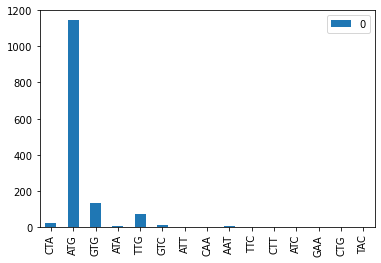

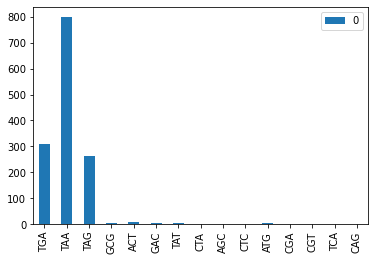

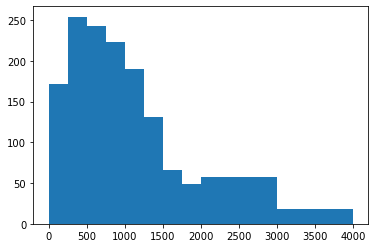

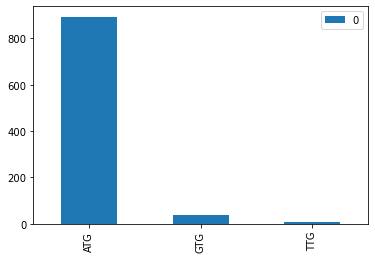

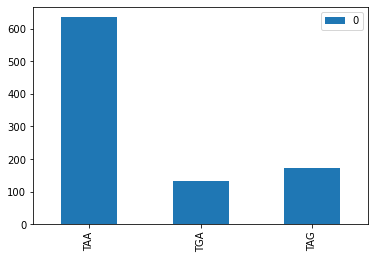

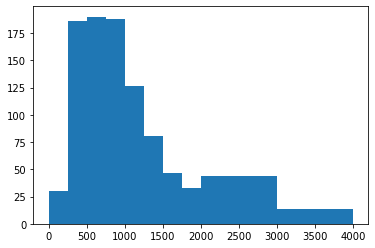

In [60]:
import pandas
letter_counts = Counter(start)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
letter_counts = Counter(end)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
x = np.array(length)
#plt.savefig("annoted_missed.png")
#y = .4 * x + np.random.randn(100000) + 5

fig, axs = plt.subplots()

# We can set the number of bins with the `bins` kwarg
axs.hist(x,bins=[0,250,500,750,1000,1250,1500,1750,2000,3000,4000])
plt.savefig("annoted_missed.png")
#do not match annotated genes--short
letter_counts = Counter(perfect_start)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.savefig("start.png")
letter_counts = Counter(perfect_end)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
x_perfect=np.array(perfect_length)
fig, axs = plt.subplots()
axs.hist(x_perfect,bins=[0,250,500,750,1000,1250,1500,1750,2000,3000,4000])
plt.savefig("annoted_matched.png")

In [3]:
intergenic_freq=pickle.load(open('intergenic_freq.pickle',"rb"))
genic_freq=pickle.load(open("genic_freq.pickle","rb"))
start_freq=pickle.load(open("start_freq.pickle","rb"))
stop_freq=pickle.load(open("stop_freq.pickle","rb"))

In [7]:
print(intergenic_freq)
print(start_freq['ATG'],genic_freq['ATG'])
print(start_freq['GTG'],genic_freq['GTG'])
print(start_freq['TTG'],genic_freq['TTG'],genic_freq["TGA"])
print(stop_freq)

{'A': 0.26576040901643977, 'C': 0.24380731785398188, 'G': 0.22597028416473647, 'T': 0.265324463777941}
0.8876523582405935 0.023487978523801765
0.07472178060413355 0.028448864158851592
0.03762586115527292 0.02261679860740277 0.0
{'TCA': 0.0, 'TCC': 0.0, 'TCG': 0.0, 'TCT': 0.0, 'TTC': 0.0, 'TTT': 0.0, 'TTA': 0.0, 'TTG': 0.0, 'TAC': 0.0, 'TAT': 0.0, 'TAA': 0.643879173290938, 'TAG': 0.1664016958134605, 'TGC': 0.0, 'TGT': 0.0, 'TGA': 0.1897191308956015, 'TGG': 0.0, 'CTA': 0.0, 'CTC': 0.0, 'CTG': 0.0, 'CTT': 0.0, 'CCA': 0.0, 'CCC': 0.0, 'CCG': 0.0, 'CCT': 0.0, 'CAC': 0.0, 'CAT': 0.0, 'CAA': 0.0, 'CAG': 0.0, 'CGA': 0.0, 'CGC': 0.0, 'CGG': 0.0, 'CGT': 0.0, 'ATA': 0.0, 'ATC': 0.0, 'ATT': 0.0, 'ATG': 0.0, 'ACA': 0.0, 'ACC': 0.0, 'ACG': 0.0, 'ACT': 0.0, 'AAC': 0.0, 'AAT': 0.0, 'AAA': 0.0, 'AAG': 0.0, 'AGC': 0.0, 'AGT': 0.0, 'AGA': 0.0, 'AGG': 0.0, 'GTA': 0.0, 'GTC': 0.0, 'GTG': 0.0, 'GTT': 0.0, 'GCA': 0.0, 'GCC': 0.0, 'GCG': 0.0, 'GCT': 0.0, 'GAC': 0.0, 'GAT': 0.0, 'GAA': 0.0, 'GAG': 0.0, 'GGA': 